In [1]:
import os

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
sns.set()

In [2]:
dataset_path = os.path.join("data", "cluster.dat")

## Utility functions

In [3]:
def get_range(data, feature=0):
    return [min(data[:, feature]), max(data[:, feature])]

def plot_data(data, plot_title="Scatter plot"):
    plt.figure(figsize=(12, 8))
    plt.title(plot_title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.scatter(data[:, 0], data[:, 1])
    plt.show()

def plot_data_with_labels(data, clusters_center, labels, plot_title="Scatter plot"):
    plt.figure(figsize=(12, 8))
    plt.title(plot_title)
    plt.xlabel('Feature 0')
    plt.ylabel('Feature 1')

    c1_points = np.where(labels == 0)
    c2_points = np.where(labels == 1)
    c3_points = np.where(labels == 2)

    plt.scatter(data[c1_points, 0], data[c1_points, 1], color="red")
    plt.scatter(data[c2_points, 0], data[c2_points, 1], color="blue")
    plt.scatter(data[c3_points, 0], data[c3_points, 1], color="green")
    plt.scatter(clusters_center[:, 0], clusters_center[:, 1], marker='x', color='black', s=100)
    plt.show()

## Load and analyze the dataset

Simple analysis of the dataset, observing:
- The number of data in the dataset
- The number of features for each data in the dataset;
- The way the data is distributed

Number of samples in the dataset: 573
Number of features per sample: 2
Shape of the dataset: (573, 2)
Example of data: [1555.     28.65] <class 'numpy.ndarray'>

Range feature 0: [335.0, 3635.0]
Range feature 1: [1.95, 29.15]
Features data type:  <class 'numpy.float64'>


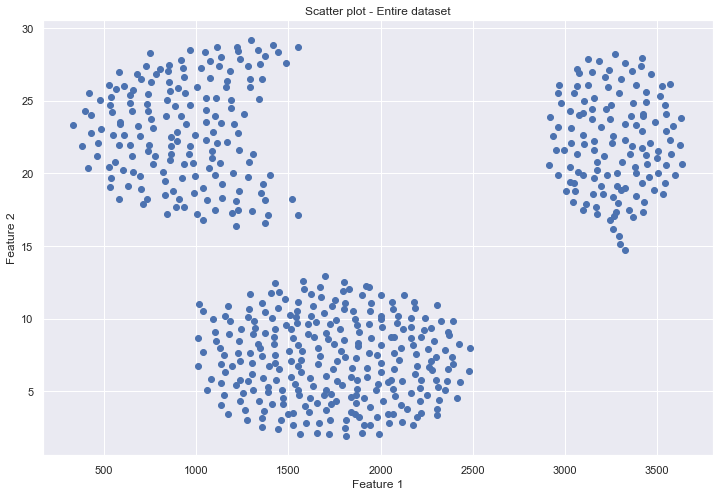

In [4]:
data = np.genfromtxt(dataset_path, delimiter=' ')

range_f0 = get_range(data, feature=0)
range_f1 = get_range(data, feature=1)

print("Number of samples in the dataset:", data.shape[0])
print("Number of features per sample:", data.shape[1])
print("Shape of the dataset:", data.shape)
print("Example of data: {} {}".format(data[0], type(data[0])))

print()
print("Range feature 0: {}".format(range_f0))
print("Range feature 1: {}".format(range_f1))
print("Features data type: ", type(data[0][0]))

plot_data(data, plot_title="Scatter plot - Entire dataset")

## Feature scaling

Applying a min-max scaling (normalization) to the data

In [11]:
for i in range(data.shape[1]):
    x_min = min(data[:, i])
    x_max = max(data[:, i])
    diff = x_max - x_min
    for j in range(data.shape[0]):
        data[j][i] = (data[j][i] - x_min) / diff

range_f0 = get_range(data, feature=0)
range_f1 = get_range(data, feature=1)

print("Range feature 0 after feature scaling: {}".format(range_f0))
print("Range feature 1 after feature scaling: {}".format(range_f1))
print("Example of data: {} {}".format(data[0], type(data[0])))

Range feature 0 after feature scaling: [0.0, 1.0]
Range feature 1 after feature scaling: [0.0, 1.0]
Example of data: [0.36969697 0.98161765] <class 'numpy.ndarray'>


## Splitting the dataset and analysis of each set 

Spliting the dataset into training and test set, with respectively 90% and 10% of the data in each set.

* The **training set** will be used to run k-means and define the clusters.
* The **test set** will be used to evaluate the performance of the algorithm.

In addition to the split of data, this cell makes a simple analysis of the set.

Training set
Number of samples: 515
Shape: (515, 2)
Range feature 0: [655.0, 3550.0]
Range feature 1: [2.85, 28.65]

Test set
Number of samples: 58
Shape: (58, 2)
Range feature 0: [655.0, 3550.0]
Range feature 1: [2.85, 28.65]


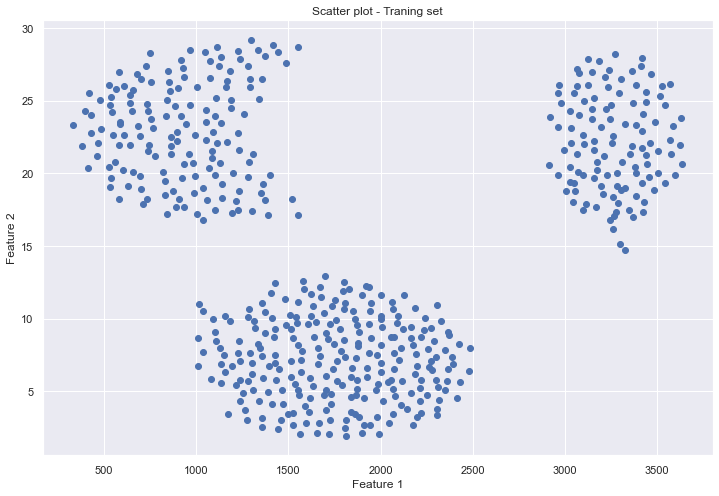

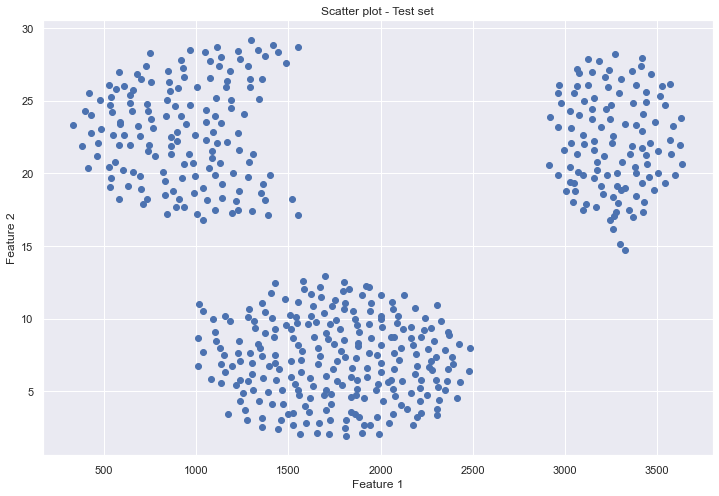

In [5]:
train_data, test_data = train_test_split(data,
                                         test_size=0.10,
                                         random_state=27,
                                         shuffle=True)
print("Training set")
print("Number of samples:", train_data.shape[0])
print("Shape:", train_data.shape)
print("Range feature 0: {}".format(get_range(test_data, feature=0)))
print("Range feature 1: {}".format(get_range(test_data, feature=1)))

print("\nTest set")
print("Number of samples:", test_data.shape[0])
print("Shape:", test_data.shape)
print("Range feature 0: {}".format(get_range(test_data, feature=0)))
print("Range feature 1: {}".format(get_range(test_data, feature=1)))

plot_data(train_data, "Scatter plot - Traning set")
plot_data(train_data, "Scatter plot - Test set")

## Algorithm implementation (k-means)

In [6]:
class KMeans():
    def __init__(self, n_clusters=3, n_features=2, init="random",
                 max_iterations=300, tolerance=0.0001):
        self.init = init
        self.tolerance = tolerance
        self.n_clusters = n_clusters
        self.n_features = n_features
        self.max_iterations = max_iterations
        
        self.clusters_center = np.zeros((self.n_clusters, self.n_features))

    def init_clusters(self, data, init="random"):
        if init == "random":
            self.clusters_center = np.random.rand(self.n_clusters, self.n_features)
            for i in range(self.n_features):
                self.clusters_center[:, i] *= np.max(data[:, i])

    def get_distance(self, p1, p2):
        return np.sqrt(sum((p1 - p2) ** 2))
    
    def get_diff_pos_cluster(self):
        diff = 0
        
        for cluster, old_cluster in zip(self.clusters_center, self.old_clusters_center):
            diff += self.get_distance(cluster, old_cluster)
        
        return diff

    def assign_datapoints_to_clusters(self, data):
        labels = np.zeros(data.shape[0], dtype=np.int)
        
        for idx, datapoint in enumerate(data):
            best_distance = np.Inf
            for cluster_id, cluster_center in enumerate(self.clusters_center):
                distance = self.get_distance(datapoint, cluster_center)
                if distance < best_distance:
                    best_distance = distance
                    labels[idx] = cluster_id

        return labels

    def update_clusters_center(self, data):
        self.old_clusters_center = self.clusters_center
        self.clusters_center = np.zeros((self.n_clusters, self.n_features))
        counter = np.zeros(self.n_clusters)
        
        for i in range(len(self.labels)):
            label = self.labels[i]
            counter[label] += 1
            for j in range(self.n_features):
                self.clusters_center[label][j] += data[i][j]
        
        for i in range(self.n_clusters):
            if counter[i] > 0:
                self.clusters_center[i] /= counter[i]
            else:
                self.clusters_center[i] = self.old_clusters_center[i]

    def fit(self, data):
        self.labels = np.zeros(data.shape[0], dtype=np.int)
        self.range_f0 = get_range
        n_iterations = 1
        diff_pos_cluster = np.Inf

        self.init_clusters(data)

        while n_iterations <= self.max_iterations and diff_pos_cluster > self.tolerance:
            self.labels = self.assign_datapoints_to_clusters(data)
            self.update_clusters_center(data)
            diff_pos_cluster = self.get_diff_pos_cluster()
            n_iterations += 1
        
        return self.labels, self.clusters_center, n_iterations
    
    def predict(self, data):
        return self.assign_datapoints_to_clusters(data)

## Training the algorithm

In [7]:
kmeans = KMeans()
labels_train, clusters_center, n_iterations = kmeans.fit(train_data)

print("Executed {} iterations".format(n_iterations))
print("Clusters center")
for i, cluster in enumerate(clusters_center):
    print("C{:}: {:}".format(i, cluster))

Executed 7 iterations
Clusters center
C0: [3264.39130435   22.07826087]
C1: [1912.67195767    7.49417989]
C2: [1019.43127962   18.33127962]


<Figure size 864x576 with 0 Axes>

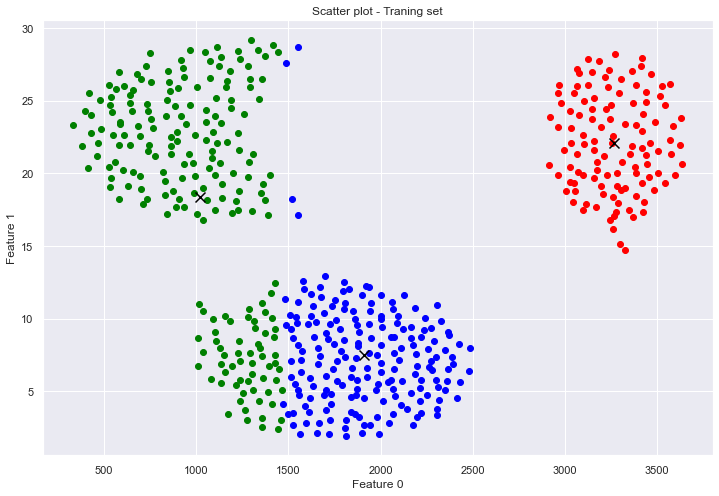

In [8]:
plt.figure(figsize=(12, 8))

plot_data_with_labels(train_data, clusters_center, labels_train, plot_title="Scatter plot - Traning set")

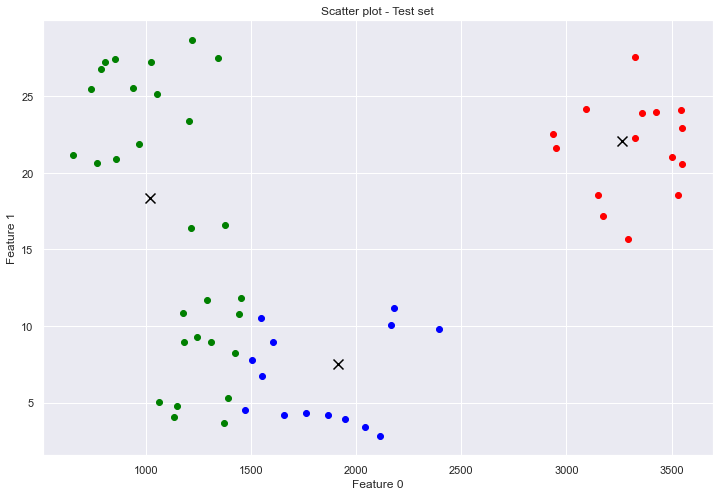

In [9]:
labels_test = kmeans.predict(test_data)
plot_data_with_labels(test_data, clusters_center, labels_test, plot_title="Scatter plot - Test set")